In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

In [3]:
T = 30/365
r = 0.0
sig = 0.2

M = 1000
N = 30

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [4]:
np.random.seed(1234)
S0 = 100

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

In [5]:
np.maximum(S[1, 30], 0)

103.17722506100667

In [12]:
a = []

K = 100

for i in range(M):
    cost = 0
    hedge = 0
    for j in range(N):
        d1 = (np.log(S[i,j]/K)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
        delta = norm.cdf(d1)
        cost = cost + (delta - hedge) * S[i,j]
        hedge = delta
    
    # 마지막 항의 delta = 0 이라 두고 하는 것
    # cost = cost + (0 - hedge) * S[i,N] 
    
    cost = cost + (0 - hedge) * S[i,N]  
    a.append(cost)

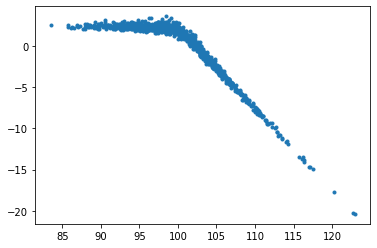

In [13]:
plt.plot(S[:, -1], a, marker=".", linestyle='none')
plt.show()

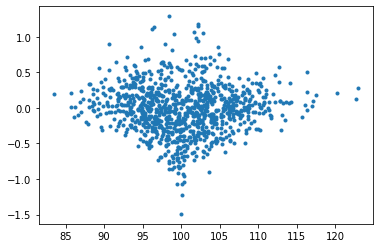

In [35]:
a = []

K = 100

for i in range(M):
    cost = 0
    price = S[i, 0]
    for j in range(N):
        # 현재 기초 자산의 가격으로 보유해야하는 주식의 개수를 정하는 것 
        d1 = (np.log(price/K)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
        delta = norm.cdf(d1)
        # cost = cost + delta * (S[i, j+1] - price)
        cost = cost + delta * (price - S[i, j+1])
        price = S[i, j+1]
    
    # 마지막 항의 delta = 0 이라 두고 하는 것
    # cost = cost + (0 - hedge) * S[i,N] #+ np.maximum(, 0)
    
    cost = cost + np.maximum(S[i,N]-K,0) - bscall(S0, K, T, r, sig)
    a.append(cost)

plt.plot(S[:, -1], a, marker=".", linestyle='none')
plt.show()

In [12]:
my_input = []

hedge_cost = tf.keras.layers.Input(shape = (1, ), name = "hedge_cost")
my_input = my_input + [hedge_cost]

price = tf.keras.layers.Input(shape = (1,), name = "price")
my_input = my_input + [price]

for j in range(3):
    delta = tf.keras.layers.Dense(1)(price)
 
    new_price = tf.keras.layers.Input(shape = (1,), name = "S_" + str(j))
    my_input = my_input + [new_price] # input이 계속해서 연결됨 

    price_inc = tf.keras.layers.Subtract(name = "price_inc_" + str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name = "multiply_" + str(j))([delta, price_inc])

    hedge_cost = tf.keras.layers.Add(name = "cost_" + str(j))([hedge_cost, cost])
    price = new_price

model = tf.keras.Model(inputs=my_input, outputs=hedge_cost)


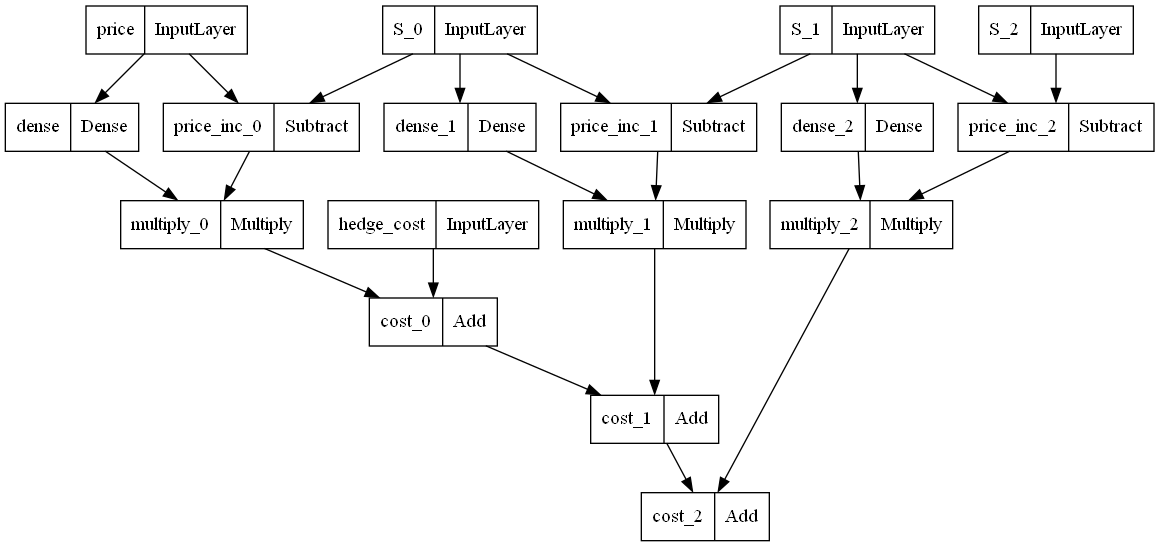

In [13]:
tf.keras.utils.plot_model(model)

In [14]:
K = 100
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name = "premium")
my_input = my_input + [premium]

hedge_cost = tf.keras.layers.Input(shape = (1, ), name = "hedge_cost")
my_input = my_input + [hedge_cost]

price = tf.keras.layers.Input(shape = (1,), name = "price")
my_input = my_input + [price]

for j in range(N):
    
    #delta = tf.keras.layers.Dense(32, activation='tanh')(price_set)
    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    # delta = tf.keras.layers.BatchNormalization()(delta)
    # delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    # delta = tf.keras.layers.BatchNormalization()(delta)
    # delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.Dense(1)(delta)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    #info_set = tf.keras.layers.Concatenate()([price, new_price])
    price = new_price
    
# 0.5 * (tf.abs(x-K) + x - K)
payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(x-K,0), name='payoff')(price)
cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="cum_cost-premium")([cum_cost, premium])
model = tf.keras.Model(inputs=my_input, outputs=cum_cost)



In [15]:
bscall(S0, K, T, r, sig)

2.2871506280449694

In [16]:
p = 2.2871506280449694 * np.ones([M, 1])
c = np.zeros([M, 1])
SS = [S[:, i].reshape(M,1) for i in range(N+1)]
x = [p] + [c] + [SS]
y = np.zeros([M, 1])

In [20]:
model.compile(loss = "mse", optimizer = "adam")
hist = model.fit(x, y, epochs = 40, validation_split = 0.2)

Epoch 1/40
25/25 [==============================] - 20s 73ms/step - loss: 3.0784 - val_loss: 3.0751
Epoch 2/40
25/25 [==============================] - 0s 13ms/step - loss: 3.0482 - val_loss: 2.8597
Epoch 3/40
25/25 [==============================] - 0s 18ms/step - loss: 3.0110 - val_loss: 3.1809
Epoch 4/40
25/25 [==============================] - 0s 12ms/step - loss: 2.9640 - val_loss: 2.6797
Epoch 5/40
25/25 [==============================] - 0s 10ms/step - loss: 2.9694 - val_loss: 2.8097
Epoch 6/40
25/25 [==============================] - 0s 10ms/step - loss: 2.9539 - val_loss: 2.8790
Epoch 7/40
25/25 [==============================] - 0s 10ms/step - loss: 2.9089 - val_loss: 2.8848
Epoch 8/40
25/25 [==============================] - 0s 10ms/step - loss: 2.8566 - val_loss: 2.8109
Epoch 9/40
25/25 [==============================] - 0s 9ms/step - loss: 2.9056 - val_loss: 3.0714
Epoch 10/40
25/25 [==============================] - 0s 9ms/step - loss: 2.9218 - val_loss: 2.9069
Epoch 11/4

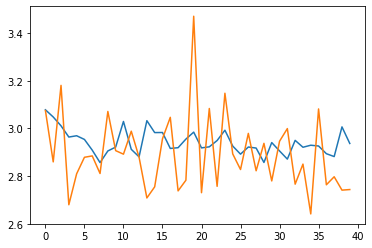

In [23]:
plt.plot(hist.history["loss"], label = "train_loss")
plt.plot(hist.history["val_loss"], label = "val_loss")
plt.show()

32/32 [==============================] - 0s 2ms/step


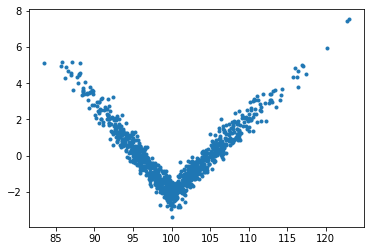

In [25]:
plt.plot(S[:, -1], model.predict(x), linestyle = "none", marker = ".")
plt.show()